In [1]:
# Must be included at the beginning of each new notebook. Remember to change the app name.
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg
spark = SparkSession.builder.appName('722').getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/20 05:25:45 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# Import dataset by using pandas
import pandas as pd

crime_data_pd=pd.read_excel("Crime.xlsx")
education_data_pd=pd.read_excel("Education.xlsx")

#Transfer pandas dataframe to spark dataframe
crime_data= spark.createDataFrame(crime_data_pd)
education_data= spark.createDataFrame(education_data_pd)

In [3]:
#2 Data Understanding
#2.2 Data Decription & 3.1 Data selection
crime_data.show()


crime_data_pd=crime_data.toPandas()
crime_data_pd.describe()

+--------------+----+-----------------------------------+-------------------------------------+-----------------------------------+-----------------------------------------------------+------------------------------------+
|        Region|year|Total amount of convicted juveniles|Total amount of family violence cases|Total amount of people with charges|Total amount of harmful digital communication offense|Total amount of drugs offences cases|
+--------------+----+-----------------------------------+-------------------------------------+-----------------------------------+-----------------------------------------------------+------------------------------------+
|     Northland|2014|                                123|                                  692|                               4335|                                                  NaN|                                 339|
|     Northland|2015|                                138|                                  817|             

,year,Total amount of convicted juveniles,Total amount of family violence cases,Total amount of people with charges,Total amount of harmful digital communication offense,Total amount of drugs offences cases
count,144.000000,144.000000,144.000000,144.000000,128.000000,144.000000
mean,2018.000000,97.979167,822.611111,4477.715278,5.015625,364.430556
std,2.591001,50.115736,292.376975,1996.337747,4.186563,156.661260
min,2014.000000,9.000000,298.000000,1714.000000,0.000000,118.000000
25%,2016.000000,63.000000,631.250000,3027.250000,2.000000,243.500000
50%,2018.000000,91.500000,816.000000,3938.000000,4.000000,337.000000
75%,2020.000000,123.750000,962.500000,5755.750000,7.000000,465.000000
max,2022.000000,297.000000,1765.000000,11409.000000,17.000000,781.000000


In [4]:
education_data.show()

education_data_pd=education_data.toPandas()
education_data_pd.describe()

+--------------+----+-----------------------+------------------------+-------------------------------------------+---------------------+-----------------------------------------------+
|        Region|year|Total amount of schools|Total amount of Students|Total amount of student attending regularly|Mean household income|Participation in ECE(early childhood education)|
+--------------+----+-----------------------+------------------------+-------------------------------------------+---------------------+-----------------------------------------------+
|     Northland|2014|                  151.0|                 22169.0|                                  12946.696|              66248.0|                                         7028.0|
|     Northland|2015|                  152.0|                 20037.0|                         12162.458999999999|              68880.0|                                         6939.0|
|     Northland|2016|                  152.0|                 22336.0|     

,year,Total amount of schools,Total amount of Students,Total amount of student attending regularly,Mean household income,Participation in ECE(early childhood education)
count,144.000000,108.000000,108.000000,144.000000,95.000000,108.000000
mean,2018.000000,182.583333,52216.333333,24485.014646,97417.645614,16171.768519
std,2.591001,93.899442,57362.680669,34992.301305,18537.215247,12294.976168
min,2014.000000,83.000000,6064.000000,0.000000,66248.000000,3354.000000
25%,2016.000000,126.000000,16431.500000,2165.319000,83349.000000,7733.250000
50%,2018.000000,149.000000,30226.500000,12284.099500,94207.000000,13851.500000
75%,2020.000000,214.500000,67850.500000,31092.127500,106600.000000,19168.250000
max,2022.000000,433.000000,244549.000000,159032.139000,151179.000000,54040.000000


In [5]:
#2.3 Data exploration/Display value for each column
def group_and_sum(dataframe, columns):
    for column in columns:
        dataframe.groupBy('Region').avg(column).show()
    return dataframe

    
        

crime_columns = [
    "Total amount of convicted juveniles",
    "Total amount of family violence cases",
    "Total amount of drugs offences cases",
    "Total amount of people with charges",
    "Total amount of harmful digital communication offense"
]

education_columns = [
    "Total amount of schools",
    "Total amount of Students",
    "Total amount of student attending regularly",
    "Participation in ECE(early childhood education)",
    "Mean household income"
]



crime_data_1=group_and_sum(crime_data, crime_columns)
education_data_1=group_and_sum(education_data, education_columns)



+--------------------+----------------------------------------+
|              Region|avg(Total amount of convicted juveniles)|
+--------------------+----------------------------------------+
|          Wellington|                      20.666666666666668|
|            Auckland|                                    85.0|
|             Waikato|                      135.66666666666666|
|      South Auckland|                      203.66666666666666|
|               Otago|                                    55.0|
|       Bay of Plenty|                                    94.0|
|          Canterbury|                      152.33333333333334|
|           Northland|                       96.33333333333333|
|           Southland|                      50.666666666666664|
|Nelson/Marlboroug...|                      58.666666666666664|
|           Waitematā|                      123.66666666666667|
|  Taranaki/Whanganui|                                    82.0|
|            Waiariki|                  

+--------------------+------------------------------------------------+
|              Region|avg(Total amount of student attending regularly)|
+--------------------+------------------------------------------------+
|          Wellington|                              45974.259999999995|
|            Auckland|                              142935.31611111114|
|             Waikato|                              39085.978444444445|
|      South Auckland|                               6566.537666666666|
|               Otago|                               18370.62211111111|
|       Bay of Plenty|                              28408.485444444443|
|          Canterbury|                              51655.546111111114|
|           Northland|                               12680.28388888889|
|           Southland|                               9480.148444444443|
|Nelson/Marlboroug...|                              4014.8347777777776|
|           Waitematā|                                          

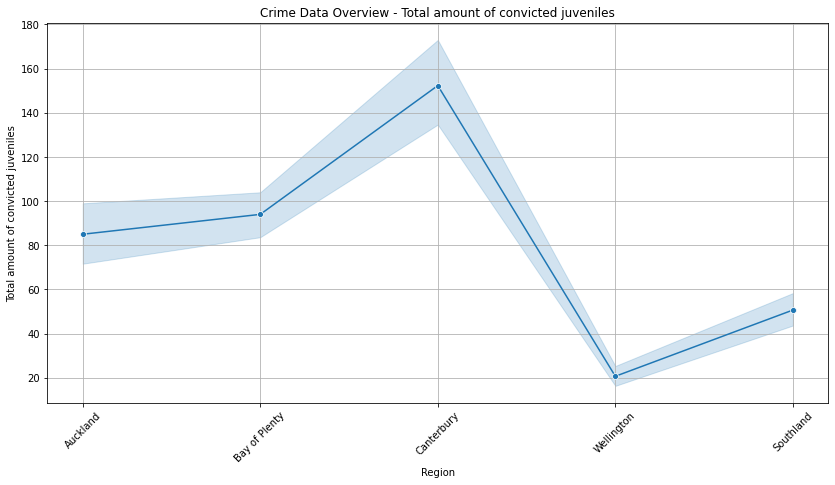

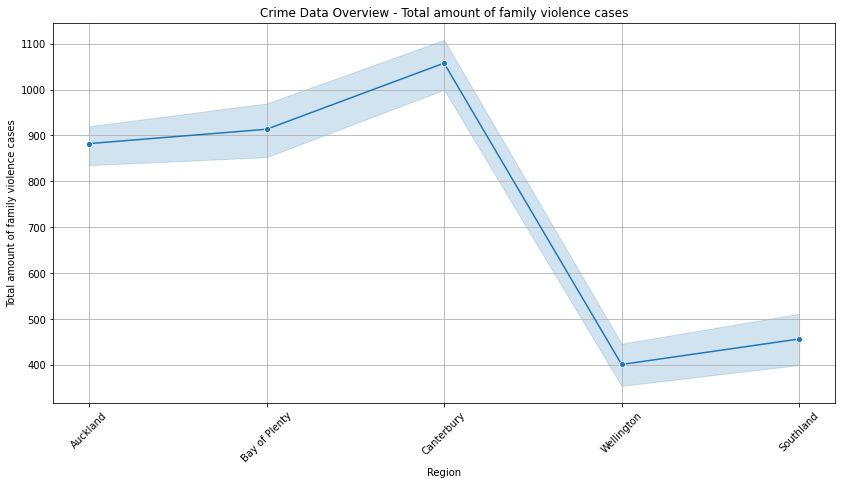

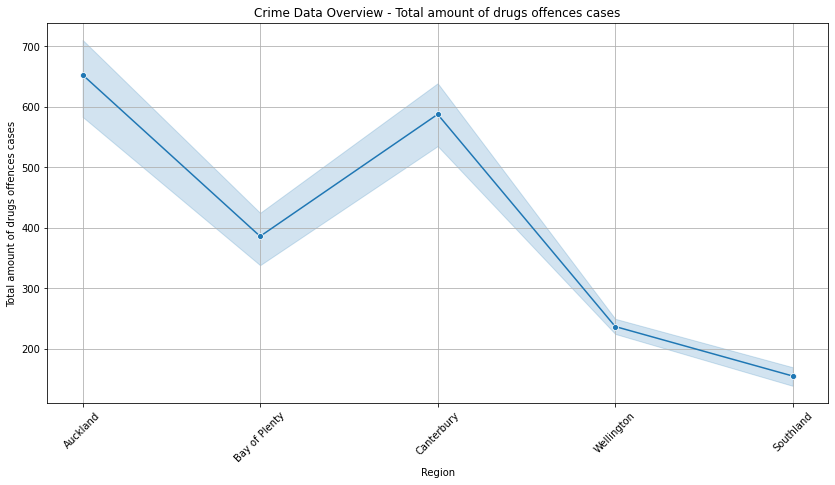

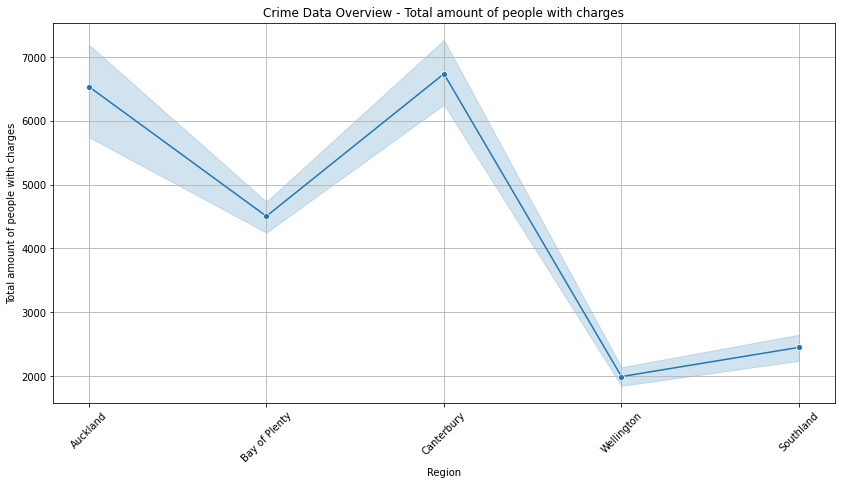

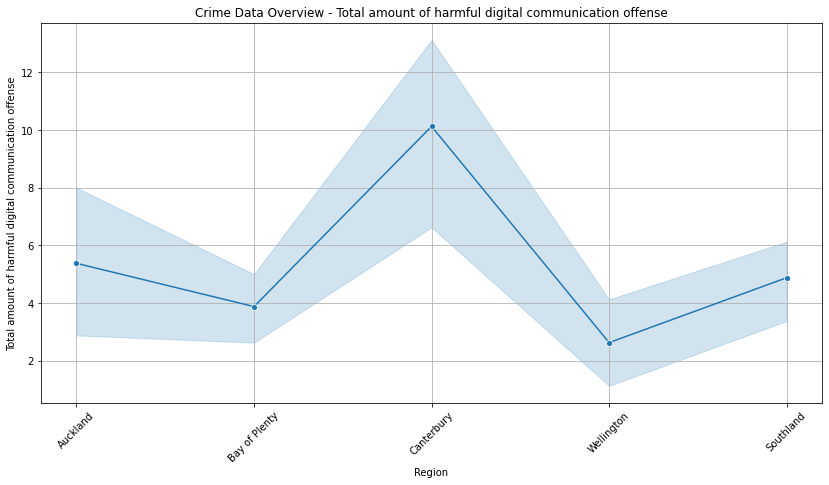

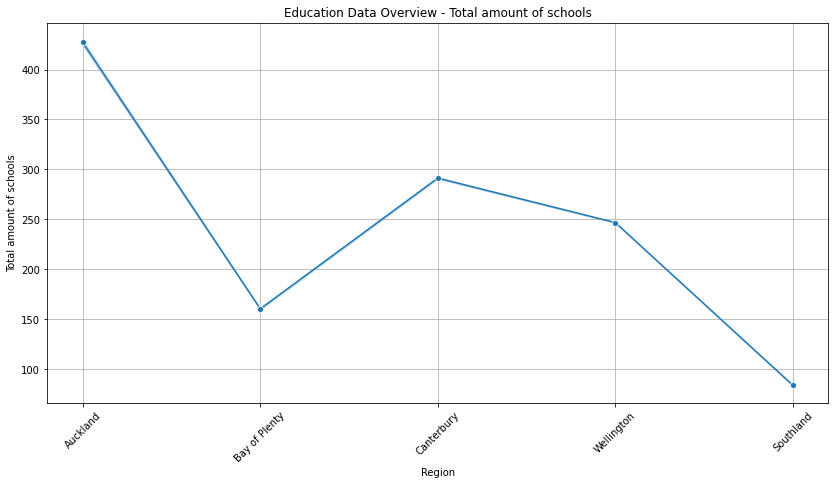

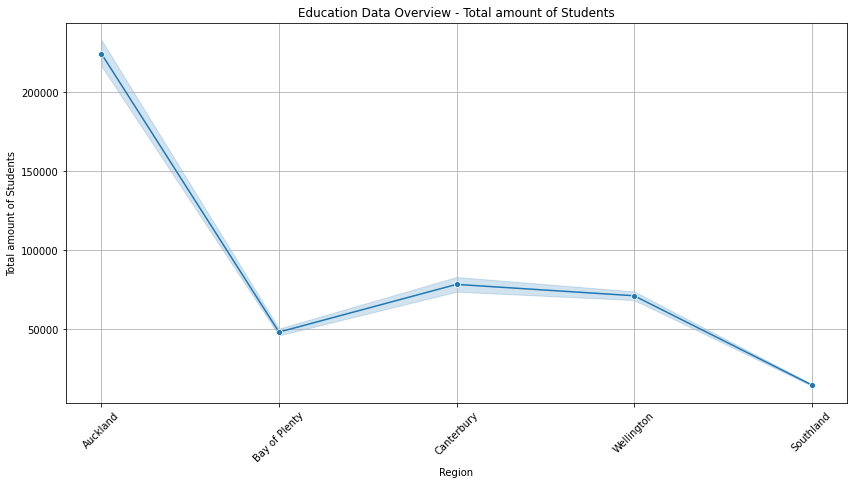

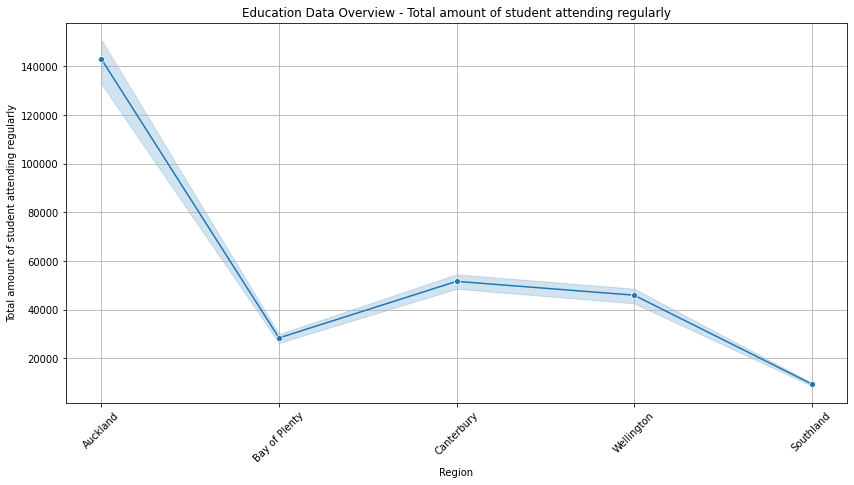

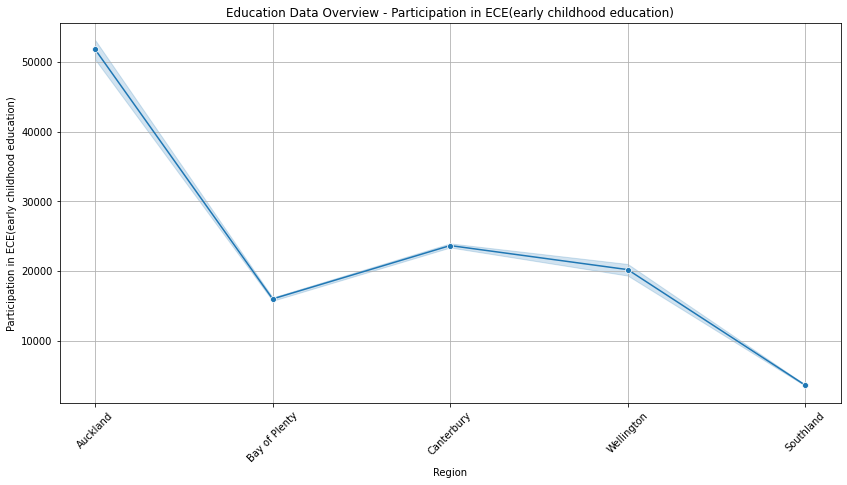

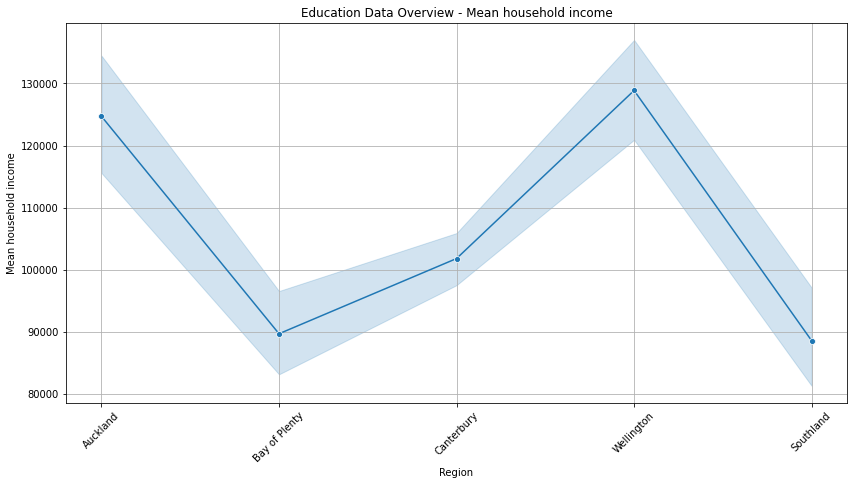

In [6]:
#Draw line for each column
import seaborn as sns
import matplotlib.pyplot as plt

crime_data_1_pd=crime_data_1.toPandas()
education_data_1_pd=education_data_1.toPandas()

selected_regions = ['Canterbury', 'Wellington', 'Auckland', 'Southland', 'Bay of Plenty']


def plot_columns(dataframe, columns, title_prefix):
    for column in columns:
        plt.figure(figsize=(14, 7))
        sns.lineplot(data=dataframe[dataframe['Region'].isin(selected_regions)].set_index('Region')[column], marker='o')
        plt.title(f'{title_prefix} - {column}')
        plt.xlabel('Region')
        plt.ylabel(column)
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.show()


crime_columns = [
    "Total amount of convicted juveniles",
    "Total amount of family violence cases",
    "Total amount of drugs offences cases",
    "Total amount of people with charges",
    "Total amount of harmful digital communication offense"
]

education_columns = [
    "Total amount of schools",
    "Total amount of Students",
    "Total amount of student attending regularly",
    "Participation in ECE(early childhood education)",
    "Mean household income"
]


plot_columns(crime_data_1_pd, crime_columns, 'Crime Data Overview')


plot_columns(education_data_1_pd, education_columns, 'Education Data Overview')

In [7]:
#2.4 Data Quality
#2.4.1 Calculate Missing Value

from pyspark.sql.functions import col, sum as spark_sum, isnan

def calculate_total_missing_values(dataframe):

    missing_counts = dataframe.select([
        (spark_sum(col(column).isNull().cast("int")) + spark_sum(isnan(col(column)).cast("int"))).alias(column)
        for column in dataframe.columns
    ])
    
    total_missing_values = missing_counts.select(
        [spark_sum(col(column)) for column in missing_counts.columns]
    ).first()

    return sum(total_missing_values)


total_missing_crime_data = calculate_total_missing_values(crime_data)
total_missing_education_data = calculate_total_missing_values(education_data)


print(f"Total missing values in crime_data: {total_missing_crime_data}")
print(f"Total missing values in education_data: {total_missing_education_data}")


Total missing values in crime_data: 16
Total missing values in education_data: 157


In [8]:
#3 Data Preparation
#3.1 Data selection
#checking basic info for dataset and each column, crime dataset first
crime_data.show()


+--------------+----+-----------------------------------+-------------------------------------+-----------------------------------+-----------------------------------------------------+------------------------------------+
|        Region|year|Total amount of convicted juveniles|Total amount of family violence cases|Total amount of people with charges|Total amount of harmful digital communication offense|Total amount of drugs offences cases|
+--------------+----+-----------------------------------+-------------------------------------+-----------------------------------+-----------------------------------------------------+------------------------------------+
|     Northland|2014|                                123|                                  692|                               4335|                                                  NaN|                                 339|
|     Northland|2015|                                138|                                  817|             

In [9]:
#checking basic info for dataset and each column, education dataset first
education_data.show()

+--------------+----+-----------------------+------------------------+-------------------------------------------+---------------------+-----------------------------------------------+
|        Region|year|Total amount of schools|Total amount of Students|Total amount of student attending regularly|Mean household income|Participation in ECE(early childhood education)|
+--------------+----+-----------------------+------------------------+-------------------------------------------+---------------------+-----------------------------------------------+
|     Northland|2014|                  151.0|                 22169.0|                                  12946.696|              66248.0|                                         7028.0|
|     Northland|2015|                  152.0|                 20037.0|                         12162.458999999999|              68880.0|                                         6939.0|
|     Northland|2016|                  152.0|                 22336.0|     

In [10]:
#drop the unnecessary column
crime_data=crime_data.drop("Total amount of harmful digital communication offense")
crime_data.show()

+--------------+----+-----------------------------------+-------------------------------------+-----------------------------------+------------------------------------+
|        Region|year|Total amount of convicted juveniles|Total amount of family violence cases|Total amount of people with charges|Total amount of drugs offences cases|
+--------------+----+-----------------------------------+-------------------------------------+-----------------------------------+------------------------------------+
|     Northland|2014|                                123|                                  692|                               4335|                                 339|
|     Northland|2015|                                138|                                  817|                               4528|                                 341|
|     Northland|2016|                                117|                                  772|                               4435|                        

In [11]:
#3.2 Data cleaning
#3.2.1 Missing value

def calculate_mean_values(dataframe, exclude_columns):
    dataframe = dataframe.fillna(0)
    mean_values = dataframe.agg(
        *[avg(col(column)).alias(column) for column in dataframe.columns if column not in exclude_columns]
    ).first().asDict()
    return mean_values

def replace_missing_values_with_mean(dataframe, exclude_columns):
    mean_values = calculate_mean_values(dataframe, exclude_columns)
    dataframe = dataframe.fillna(mean_values)
    return dataframe


exclude_columns=["Region","Year"]

crime_data=replace_missing_values_with_mean(crime_data, exclude_columns)
education_data=replace_missing_values_with_mean(education_data, exclude_columns)


total_missing_crime_data_update=calculate_total_missing_values(crime_data)
total_missing_education_data_update=calculate_total_missing_values(education_data)

print(f"Total missing values in crime_data after dealing: {total_missing_crime_data_update}")
print(f"Total missing values in education_data after dealing: {total_missing_education_data_update}")

Total missing values in crime_data after dealing: 0
Total missing values in education_data after dealing: 0


In [12]:
#3.2.1 Outliers and Extreme values，use quantile(0.1/0.9) to define outliners and extreme values
from pyspark.sql.functions import col, mean, when

spark = SparkSession.builder.appName("OutlierReplacement").getOrCreate()

crime_data_columns = crime_data.columns
print(crime_data_columns)

crime_data_needed_columns = [
    'Total amount of convicted juveniles', 
    'Total amount of family violence cases', 
    'Total amount of people with charges', 
    'Total amount of drugs offences cases'
]

education_data_columns = education_data.columns
print(education_data_columns)

education_data_needed_columns = [
    'Total amount of schools', 
    'Total amount of Students', 
    'Total amount of student attending regularly', 
    'Mean household income', 
    'Participation in ECE(early childhood education)'
]

def replace_outliers(dataframe, columns, lower_quantile=0.1, upper_quantile=0.9):
    for column in columns:
        Q1 = dataframe.approxQuantile(column, [lower_quantile], 0.05)[0]
        Q3 = dataframe.approxQuantile(column, [upper_quantile], 0.05)[0]
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 3 * IQR
        upper_bound = Q3 + 3 * IQR
        
        mean_value = dataframe.select(mean(col(column))).collect()[0][0]
        
        dataframe = dataframe.withColumn(
            column,
            when(col(column) < lower_bound, mean_value).when(col(column) > upper_bound, mean_value).otherwise(col(column))
        )
        
    return dataframe


crime_data = replace_outliers(crime_data, crime_data_needed_columns)
education_data = replace_outliers(education_data, education_data_needed_columns)


crime_data.show()
education_data.show()


['Region', 'year', 'Total amount of convicted juveniles', 'Total amount of family violence cases', 'Total amount of people with charges', 'Total amount of drugs offences cases']
['Region', 'year', 'Total amount of schools', 'Total amount of Students', 'Total amount of student attending regularly', 'Mean household income', 'Participation in ECE(early childhood education)']
+--------------+----+-----------------------------------+-------------------------------------+-----------------------------------+------------------------------------+
|        Region|year|Total amount of convicted juveniles|Total amount of family violence cases|Total amount of people with charges|Total amount of drugs offences cases|
+--------------+----+-----------------------------------+-------------------------------------+-----------------------------------+------------------------------------+
|     Northland|2014|                              123.0|                                692.0|                       

In [13]:
#Check if outliers still exist

def check_outliers(dataframe, columns, lower_quantile=0.1, upper_quantile=0.9):
    outlier_counts = {}
    for column in columns:
        Q1 = dataframe.approxQuantile(column, [lower_quantile], 0.05)[0]
        Q3 = dataframe.approxQuantile(column, [upper_quantile], 0.05)[0]
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 3 * IQR
        upper_bound = Q3 + 3 * IQR
        
        outliers = dataframe.filter((col(column) < lower_bound) | (col(column) > upper_bound))
        count_of_outliers = outliers.count()
        
        outlier_counts[column] = count_of_outliers
    
    return outlier_counts

print(check_outliers(crime_data,crime_data_needed_columns))
print(check_outliers(education_data,education_data_needed_columns))


{'Total amount of convicted juveniles': 0, 'Total amount of family violence cases': 0, 'Total amount of people with charges': 0, 'Total amount of drugs offences cases': 0}
{'Total amount of schools': 0, 'Total amount of Students': 0, 'Total amount of student attending regularly': 0, 'Mean household income': 0, 'Participation in ECE(early childhood education)': 0}


In [14]:
#3.3 Constructing new features
from pyspark.sql.functions import round

education_data = education_data.withColumn(
    "Student Attendance",
    (col("Total amount of student attending regularly") / col("Total amount of Students") * 100).cast("double")
)

education_data = education_data.withColumn("Student Attendance", round(col("Student Attendance"), 1))

education_data = education_data.drop("Total amount of student attending regularly", "Total amount of Students")

education_data.show(20)

+--------------+----+-----------------------+---------------------+-----------------------------------------------+------------------+
|        Region|year|Total amount of schools|Mean household income|Participation in ECE(early childhood education)|Student Attendance|
+--------------+----+-----------------------+---------------------+-----------------------------------------------+------------------+
|     Northland|2014|                  151.0|              66248.0|                                         7028.0|              58.4|
|     Northland|2015|                  152.0|              68880.0|                                         6939.0|              60.7|
|     Northland|2016|                  152.0|              73469.0|                                         7200.0|              55.9|
|     Northland|2017|                  151.0|              75326.0|                                         7422.0|              50.9|
|     Northland|2018|                  151.0|          

In [15]:
#3.4 Data Integrating, using join to combine two datasets (sql)

Integrated_data = crime_data.join(education_data, on=["Region", "Year"], how="left")
Integrated_data.show()

+--------------+----+-----------------------------------+-------------------------------------+-----------------------------------+------------------------------------+-----------------------+---------------------+-----------------------------------------------+------------------+
|        Region|year|Total amount of convicted juveniles|Total amount of family violence cases|Total amount of people with charges|Total amount of drugs offences cases|Total amount of schools|Mean household income|Participation in ECE(early childhood education)|Student Attendance|
+--------------+----+-----------------------------------+-------------------------------------+-----------------------------------+------------------------------------+-----------------------+---------------------+-----------------------------------------------+------------------+
|South Auckland|2015|                              297.0|                               1484.0|                            10484.0|                       

In [16]:
#4.1.1 Feature Selection, choose four of most significant fields for target variables
from pyspark.ml.feature import VectorAssembler, UnivariateFeatureSelector
from pyspark.sql.functions import col


Copy_data = Integrated_data


useless_columns = ['Region', 'year', 'Total amount of convicted juveniles']
needed_columns = []

for column in Copy_data.columns:
    if column not in useless_columns:
        needed_columns.append(column)


features_combination = VectorAssembler(
    inputCols=needed_columns,
    outputCol='useful_features_list'
)


data_with_features = features_combination.transform(Copy_data)


features_selection = UnivariateFeatureSelector(
    featuresCol='useful_features_list',
    labelCol='Total amount of convicted juveniles',
    selectionMode='numTopFeatures'
)

features_selection.setFeatureType('continuous').setLabelType('continuous').setSelectionThreshold(4)


model = features_selection.fit(data_with_features)


selected_indices = model.selectedFeatures

for indices in selected_indices:
    print(needed_columns[indices])

    
selected_feature_names = [needed_columns[i] for i in selected_indices]
    
Final_data = Integrated_data.select(['Region', 'year', 'Total amount of convicted juveniles'] + selected_feature_names)

Final_data.show()

Total amount of family violence cases
Total amount of people with charges
Total amount of drugs offences cases
Mean household income
+--------------+----+-----------------------------------+-------------------------------------+-----------------------------------+------------------------------------+---------------------+
|        Region|year|Total amount of convicted juveniles|Total amount of family violence cases|Total amount of people with charges|Total amount of drugs offences cases|Mean household income|
+--------------+----+-----------------------------------+-------------------------------------+-----------------------------------+------------------------------------+---------------------+
|South Auckland|2015|                              297.0|                               1484.0|                            10484.0|                               565.0|    64268.58564814815|
|      Auckland|2016|                               87.0|                                961.0|        

In [17]:
#4.2 Data reduction, delete those useless regions
Final_data.filter(col('Region') == 'East Coast').show()

Final_data.filter(col('Region') == 'South Auckland').show()

Final_data.show()

useless_regions=['Northern Wellington','East Coast','Waiariki','Waitematā']
Final_data=Final_data.filter(~Final_data['Region'].isin(useless_regions))


print("The count of data after data reduction:{}".format(Final_data.count()))

+----------+----+-----------------------------------+-------------------------------------+-----------------------------------+------------------------------------+---------------------+
|    Region|year|Total amount of convicted juveniles|Total amount of family violence cases|Total amount of people with charges|Total amount of drugs offences cases|Mean household income|
+----------+----+-----------------------------------+-------------------------------------+-----------------------------------+------------------------------------+---------------------+
|East Coast|2014|                              150.0|                               1080.0|                             5362.0|                               380.0|    64268.58564814815|
|East Coast|2015|                              150.0|                               1162.0|                             5097.0|                               357.0|    64268.58564814815|
|East Coast|2016|                              153.0|            

The count of data after data reduction:108


In [18]:
#4.2 Data projection
Final_data_pd=Final_data.toPandas()
Final_data_pd.describe()

,year,Total amount of convicted juveniles,Total amount of family violence cases,Total amount of people with charges,Total amount of drugs offences cases,Mean household income
count,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000
mean,2018.000000,93.500000,805.537037,4485.796296,366.379630,93427.480989
std,2.594026,55.188631,319.159657,2210.392707,170.342794,20477.189139
min,2014.000000,9.000000,298.000000,1714.000000,118.000000,64268.585648
25%,2016.000000,57.000000,570.750000,2804.500000,239.000000,80717.916667
50%,2018.000000,79.500000,770.000000,3850.000000,329.000000,90169.000000
75%,2020.000000,120.000000,958.750000,6065.000000,484.250000,103788.250000
max,2022.000000,297.000000,1765.000000,11409.000000,781.000000,151179.000000


In [19]:
#6/7 Linear Regression, find out coefficient for each field

from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler


columns_list = Final_data.columns
useless_columns = ['Region', 'year', 'Total amount of convicted juveniles']
needed_features = []

for column in columns_list:
    if column not in useless_columns:
        needed_features.append(column)

print(needed_features)


features_combination = VectorAssembler(
    inputCols=needed_features,
    outputCol='features'
)


data_with_features = features_combination.transform(Final_data)

data_with_features.printSchema()

research_data_1=data_with_features.select('features','Total amount of convicted juveniles')
research_data_1.show()

train_data_1,test_data_1 = research_data_1.randomSplit([0.2,0.8])


r1 = LinearRegression(labelCol='Total amount of convicted juveniles')
r1_training = r1.fit(train_data_1)
print("Coefficients: {} Intercept: {}".format(r1_training.coefficients,r1_training.intercept))
train_results =r1_training.evaluate(train_data_1)

r1_testing=r1.fit(test_data_1)
print("Coefficients: {} Intercept: {}".format(r1_testing.coefficients,r1_testing.intercept))
test_results =r1_testing.evaluate(test_data_1)


#evalute result by using RSME and R2 (in shohil-kishore repo)
test_results.residuals.show()
print("RSME: {}".format(test_results.rootMeanSquaredError))

print("R2: {}".format(test_results.r2))

['Total amount of family violence cases', 'Total amount of people with charges', 'Total amount of drugs offences cases', 'Mean household income']
root
 |-- Region: string (nullable = true)
 |-- year: long (nullable = true)
 |-- Total amount of convicted juveniles: double (nullable = true)
 |-- Total amount of family violence cases: double (nullable = true)
 |-- Total amount of people with charges: double (nullable = true)
 |-- Total amount of drugs offences cases: double (nullable = true)
 |-- Mean household income: double (nullable = true)
 |-- features: vector (nullable = true)

+--------------------+-----------------------------------+
|            features|Total amount of convicted juveniles|
+--------------------+-----------------------------------+
|[1104.0,5758.0,45...|                              162.0|
|[1142.0,7797.0,48...|                              153.0|
|[713.0,3030.0,234...|                               57.0|
|[1584.0,9366.0,58...|                              201.0|

24/05/20 05:26:35 WARN Instrumentation: [1f8d1a8c] regParam is zero, which might cause numerical instability and overfitting.
24/05/20 05:26:35 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/05/20 05:26:35 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
24/05/20 05:26:35 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


Coefficients: [0.05335381860926449,0.024227398831276045,-0.14208860557419895,-6.999623008519829e-05] Intercept: 7.855967010885338


24/05/20 05:26:38 WARN Instrumentation: [38df933d] regParam is zero, which might cause numerical instability and overfitting.


Coefficients: [-0.013776528751724462,0.027112994503127673,-0.06346340907434875,-0.0003386111205329902] Intercept: 36.743412711838225


/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


+--------------------+
|           residuals|
+--------------------+
|  19.038883226652448|
| -11.765862959460698|
| -10.592462162766878|
|  2.7167190598764144|
|-0.33659721666467846|
| -18.140262398761223|
|   13.57429986649516|
|  1.4902188642029799|
| -2.0074600727648146|
|  -16.16139814226228|
|  -16.92782657521638|
| -17.376997693997254|
|   6.960722178509414|
| -17.707358929695204|
|  1.7735730153650877|
| -15.330287680911816|
| -23.379755423785227|
| -15.739438668435398|
|     5.0023109834463|
|  -5.778107411800761|
+--------------------+
only showing top 20 rows

RSME: 23.615375308911485
R2: 0.8166298117353108


In [22]:
#6/7 Decision Tree models
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler


columns_list = Final_data.columns
useless_columns = ['Region', 'year', 'Total amount of convicted juveniles']
needed_features = []

for column in columns_list:
    if column not in useless_columns:
        needed_features.append(column)

print(needed_features)


features_combination = VectorAssembler(
    inputCols=needed_features,
    outputCol='features'
)


data_with_features = features_combination.transform(Final_data)

data_with_features.printSchema()

research_data_2=data_with_features.select('features','Total amount of convicted juveniles')
research_data_2.show()

train_data_2,test_data_2 = research_data_2.randomSplit([0.2,0.8])

d1 = DecisionTreeRegressor(labelCol='Total amount of convicted juveniles', featuresCol='features',maxDepth=5,seed=79)

d1_model = d1.fit(train_data_2)

#Using train dataset to test model‘s ablity, and use test dataset to check if the predict's ability
predictions_test= d1_model.transform(test_data_2)
predictions_train=d1_model.transform(train_data_2)

evaluator = RegressionEvaluator(
    labelCol='Total amount of convicted juveniles', predictionCol='prediction', metricName='rmse'
)

train_rmse_1 = evaluator.evaluate(predictions_train)
print(f"Root Mean Squared Error (RMSE) on train data = {train_rmse_1}")


test_rmse_1 = evaluator.evaluate(predictions_test)
print(f"Root Mean Squared Error (RMSE) on test data = {test_rmse_1}")

print(f"Learned regression tree model:\n{d1_model.toDebugString}")



['Total amount of family violence cases', 'Total amount of people with charges', 'Total amount of drugs offences cases', 'Mean household income']
root
 |-- Region: string (nullable = true)
 |-- year: long (nullable = true)
 |-- Total amount of convicted juveniles: double (nullable = true)
 |-- Total amount of family violence cases: double (nullable = true)
 |-- Total amount of people with charges: double (nullable = true)
 |-- Total amount of drugs offences cases: double (nullable = true)
 |-- Mean household income: double (nullable = true)
 |-- features: vector (nullable = true)

+--------------------+-----------------------------------+
|            features|Total amount of convicted juveniles|
+--------------------+-----------------------------------+
|[1104.0,5758.0,45...|                              162.0|
|[1142.0,7797.0,48...|                              153.0|
|[713.0,3030.0,234...|                               57.0|
|[1584.0,9366.0,58...|                              201.0|

24/05/20 05:28:17 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 29 (= number of training instances)


Root Mean Squared Error (RMSE) on train data = 4.717643228929885
Root Mean Squared Error (RMSE) on test data = 26.273972336131703
Learned regression tree model:
DecisionTreeRegressionModel: uid=DecisionTreeRegressor_4caf87e47450, depth=5, numNodes=27, numFeatures=4
  If (feature 1 <= 9510.5)
   If (feature 1 <= 3518.5)
    If (feature 1 <= 2212.0)
     If (feature 0 <= 379.5)
      If (feature 0 <= 351.5)
       Predict: 21.0
      Else (feature 0 > 351.5)
       Predict: 24.0
     Else (feature 0 > 379.5)
      Predict: 18.0
    Else (feature 1 > 2212.0)
     If (feature 1 <= 2773.5)
      If (feature 3 <= 95869.0)
       Predict: 52.0
      Else (feature 3 > 95869.0)
       Predict: 63.0
     Else (feature 1 > 2773.5)
      If (feature 3 <= 87242.5)
       Predict: 61.714285714285715
      Else (feature 3 > 87242.5)
       Predict: 75.0
   Else (feature 1 > 3518.5)
    If (feature 0 <= 1058.0)
     If (feature 3 <= 82454.0)
      If (feature 0 <= 699.5)
       Predict: 114.0
      El

In [21]:
#6/7 Random Forest
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler


columns_list = Final_data.columns
useless_columns = ['Region', 'year', 'Total amount of convicted juveniles']
needed_features = []

for column in columns_list:
    if column not in useless_columns:
        needed_features.append(column)

print(needed_features)


features_combination = VectorAssembler(
    inputCols=needed_features,
    outputCol='features'
)


data_with_features = features_combination.transform(Final_data)

data_with_features.printSchema()

research_data_3=data_with_features.select('features','Total amount of convicted juveniles')
research_data_3.show()

train_data_3,test_data_3 = research_data_3.randomSplit([0.2,0.8])

rf=RandomForestRegressor(labelCol='Total amount of convicted juveniles', featuresCol='features', numTrees=3, maxDepth=5)

rf_model = rf.fit(train_data_3)

predictions_test_2=rf_model.transform(test_data_3)

evaluator = RegressionEvaluator(
    labelCol='Total amount of convicted juveniles', predictionCol='prediction', metricName='rmse'
)


test_rmse_2 = evaluator.evaluate(predictions_test_2)
print(f"Root Mean Squared Error (RMSE) on test data = {test_rmse_2}")

print(f"Learned random forest model:\n{rf_model.toDebugString}")



['Total amount of family violence cases', 'Total amount of people with charges', 'Total amount of drugs offences cases', 'Mean household income']
root
 |-- Region: string (nullable = true)
 |-- year: long (nullable = true)
 |-- Total amount of convicted juveniles: double (nullable = true)
 |-- Total amount of family violence cases: double (nullable = true)
 |-- Total amount of people with charges: double (nullable = true)
 |-- Total amount of drugs offences cases: double (nullable = true)
 |-- Mean household income: double (nullable = true)
 |-- features: vector (nullable = true)

+--------------------+-----------------------------------+
|            features|Total amount of convicted juveniles|
+--------------------+-----------------------------------+
|[1104.0,5758.0,45...|                              162.0|
|[1142.0,7797.0,48...|                              153.0|
|[713.0,3030.0,234...|                               57.0|
|[1584.0,9366.0,58...|                              201.0|

24/05/20 05:26:46 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 25 (= number of training instances)


Root Mean Squared Error (RMSE) on test data = 33.415841660739034
Learned random forest model:
RandomForestRegressionModel: uid=RandomForestRegressor_2de14310c46a, numTrees=3, numFeatures=4
  Tree 0 (weight 1.0):
    If (feature 2 <= 312.5)
     If (feature 0 <= 472.5)
      If (feature 1 <= 1921.0)
       Predict: 24.0
      Else (feature 1 > 1921.0)
       If (feature 3 <= 121904.0)
        Predict: 18.0
       Else (feature 3 > 121904.0)
        Predict: 9.0
     Else (feature 0 > 472.5)
      If (feature 0 <= 601.0)
       If (feature 0 <= 561.5)
        If (feature 2 <= 173.0)
         Predict: 66.0
        Else (feature 2 > 173.0)
         Predict: 72.0
       Else (feature 0 > 561.5)
        Predict: 48.0
      Else (feature 0 > 601.0)
       If (feature 0 <= 793.0)
        If (feature 2 <= 237.0)
         Predict: 57.0
        Else (feature 2 > 237.0)
         Predict: 80.0
       Else (feature 0 > 793.0)
        Predict: 102.0
    Else (feature 2 > 312.5)
     If (feature 1 <= 